# Using Torch-ResNet34

for reference: [Kaggle](https://www.kaggle.com/code/pezhmansamadi/facerecognition-torch-resnet34/notebook?scriptVersionId=89345919)

Because I couldn't train in local device so I move to train on Colab for better performance of training.

Link: [Colab](https://colab.research.google.com/drive/1kuey9kHoyr2nHY22LeeGj_tuUMBj_nKq?usp=sharing)

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

# Handle data

In [2]:
import random

stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=64
channels = 3

transformer_1 = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

transformer_2 = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomAutocontrast(p=2),
    T.RandomEqualize(p=2),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [3]:
import os

main_dir = "../data/imgs_face_clean_original/"
list_dir = sorted(os.listdir(main_dir))

print(f"Random data: {list_dir[0:5]}")
print(f"Number of classes: {len(list_dir)}")

Random data: ['.DS_Store', 'Adriana_Lima', 'Alex_Lawther', 'Alexandra_Daddario', 'Alvaro_Morte']
Number of classes: 106


In [4]:
dataset_1 = ImageFolder(main_dir, transform=transformer_1)
dataset_2 = ImageFolder(main_dir, transform=transformer_2)
classes = dataset_1.classes

print(f"Number of dataset1: {len(dataset_1)}")
print(f"Number of classes: {len(classes)}")
print(f"Size of image: {dataset_1[0][0].size()}")

Number of dataset1: 17534
Number of classes: 105
Size of image: torch.Size([3, 224, 224])


In [5]:
dataset = ConcatDataset([dataset_1, dataset_2])

print(f"Number of total data: {len(dataset)}")

Number of total data: 35068


In [6]:
def denormal(image):
    #Flip image
    image = image.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def denormalize(x, mean=stats[0], std=stats[1]):
    # 3, H, W, B
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    # B, 3, H, W
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

Text(0.5, 1.0, 'tom_ellis')

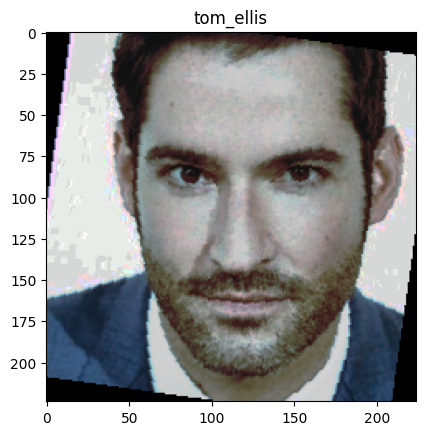

In [7]:
idx = -3
img, lbl = dataset[idx]

plt.imshow(denormal(img))
plt.title(classes[lbl])

## Split the data

In [8]:
torch.manual_seed(123)
val_len = int(len(dataset)*0.1)
print(f"Number of validation data: {val_len}")

dataset, val_ds = random_split(dataset, [len(dataset) - val_len, val_len])


Number of validation data: 3506


In [9]:
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=3)

In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

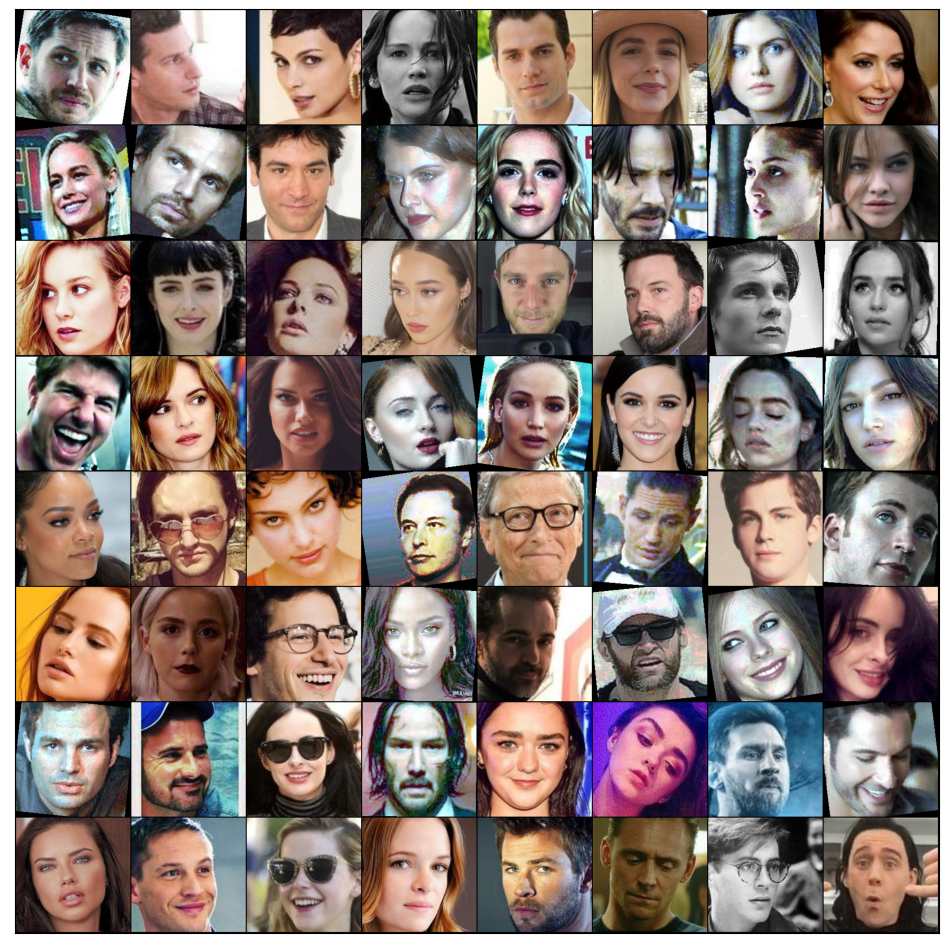

In [11]:
show_batch(dl)

## Set to train on GPU

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [13]:
torch.backends.mps.is_available()

True

# Create FaceRrecog model

In [14]:
# Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from glob import glob
from tqdm.notebook import tqdm
from torchsummary import summary
import IPython
import sys


In [15]:
class FaceRecog(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.resnet50 = models.resnet50(True)
        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])
        # Replace last layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(self.resnet50.fc.in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)

In [16]:
device

device(type='mps')

In [17]:
# Changing to `cpu` for summary all the layers
model = FaceRecog(num_classes=len(classes)).to("cpu")
model.summary((3, 224, 224))

/Users/pataweeratanaruengwatna/opt/anaconda3/envs/pytorch-resource/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/pataweeratanaruengwatna/opt/anaconda3/envs/pytorch-resource/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

## Setting hyperparameters 

In [21]:
LEARNING_RATE = 1e-3
EPOCHS = 10

model = FaceRecog(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model

FaceRecog(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [22]:
def train(epoch, n_epochs, model, dl, loss_func, device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)
    
    epoch_loss = 0.0
    epochs_acc = 0
    
    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)
        
        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        
        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))

            
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [23]:
def evaluate(model, dl, loss_func, device, ds=val_ds):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')
        
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [24]:
def fit(n_epochs, model, train_dataloader, valid_dataloader, loss_func, device, optimizer):
    
    history = []
    val_loss_ref = float('inf')
    patient = 5
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        loss, acc = train(epoch, n_epochs, model, train_dataloader, loss_func, device, optimizer)
        
        torch.cuda.empty_cache()
        val_loss, val_acc = evaluate(model, valid_dataloader, loss_func, device)
        
        history.append({'loss': loss, 'acc': acc, 'val_loss': val_loss, 'val_acc': val_acc})

        statement = "[loss]={:.4f} - [acc]={:.4f} - \
[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)
        ####### Checkpoint
        if val_loss < val_loss_ref:
            patient = 5
            val_loss_ref = val_loss
            model_path = './Face_Recognition_checkpoint.pth'
            torch.save(model.state_dict(), model_path)
            print(f"[INFO] Saving model dict, Epoch={epoch + 1}")
        else:
            if patient == 0: 
                break
            print(f"[INFO] {patient} lives left!")
            patient -= 1
            

    return history

In [25]:
res = fit(EPOCHS, model, dl, val_dl, criterion, device, optimizer)

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

[loss]=4.1687 - [acc]=0.0422 - [val_loss]=3.8942 - [val_acc]=0.0716
[INFO] Saving model dict, Epoch=1


  0%|          | 0/494 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
def show_results(history):
    accuracy = [res['acc'] for res in history]
    losses = [res['loss'] for res in history]
    val_accuracy = [res['val_acc'] for res in history]
    val_losses = [res['val_loss'] for res in history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.plot(losses, '-o', label = 'Loss')
    ax1.plot(val_losses, '-o', label = 'Validation Loss')
    ax1.legend()

    ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
    ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
    ax2.legend();
    
    fig.show()

In [35]:
show_results(res)

NameError: name 'res' is not defined